## The objective of this notebook is to explore the profitablilty of a rolling cummlative trading strategy.

 Get imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import portmaker
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [22]:

def make_signal(df,coin):

    df = df.copy()
    df['Short'] = None
    df['Long'] = None
    df['Position'] = None
    df['pos_diff'] = None
    for row in range(len(df)):
        #print(df["Close"].iloc[row]> df['2'].iloc[row])
        #sell when price crosses 2
        if (df["Close"].iloc[row] > df['2'].iloc[row]) and (df["Close"].iloc[row-1] < df['2'].iloc[row-1]):
            df['Position'].iloc[row] = -1
        #buy when price greater than 2 and prev price greater than 2
        if (df["Close"].iloc[row-5:row].mean() > df['2'].iloc[row]) and df["Close"].iloc[row] > df['2'].iloc[row]:
            df['Position'].iloc[row] = 1
        #buy when price crosses over -2
        if (df["Close"].iloc[row] > df['-2'].iloc[row]) and (df["Close"].iloc[row-1] < df['-2'].iloc[row-1]):
            df['Position'].iloc[row] = 1
        # sell when price crosses under -2
        if (df["Close"].iloc[row] < df['-2'].iloc[row]) and (df["Close"].iloc[row-1] > df['-2'].iloc[row-1]):
            df['Position'].iloc[row] = -1
        #overtrading limiter
        try:
            df['pos_diff'] = df['Position'].diff()
            if(df['pos_diff'].iloc[row-2:row].mean() != 0):
                continue
        except:
            continue

    df['Position'].fillna(method='ffill',inplace=True)

    df['Market Return'] = np.log(df["Close"] / df["Close"].shift(1))
    df['Strategy Return'] = df['Market Return'] * df['Position']

    df['Strategy Return'].cumsum().plot(figsize=(12,7))
    #plt.show()
    return df

def make_bands(prices):
    #Compute the cumulative moving average of the price
    #signal = prices.copy()
    prices['-1'] = [prices["Close"][:i].mean() for i in range(len(prices))]
    vol = [prices["Close"][:i].std() for i in range(len(prices))]
    ch = [high[:i].mean() for i in range(len(high))]

    prices['2'] = [k+v for k,v in zip(prices['-1'], vol)]#addition
    prices['1'] = ch
    prices['-2'] = [k-v for k,v in zip(prices['-1'], vol)]
    return prices

def plot_signal(prices,signal):
    fig, ax1 = plt.subplots(figsize=(12,7))

    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('price', color=color)
    ax1.plot(prices[["Close",'2','-2']],color=color)#
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel("signal", color=color)  # we already handled the x-label with ax1
    ax2.plot(signal["Position"], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [23]:
end = int(portmaker.current_milli_time())
st = end-(86400000*30)


data = portmaker.get_data("BTCUSDT",st,end,candle_k='1h')



#break

2019-06-18 21:00:00 2019-06-20 21:00:00
2019-06-20 21:00:00 2019-06-22 21:00:00
2019-06-22 21:00:00 2019-06-24 21:00:00
2019-06-24 21:00:00 2019-06-26 21:00:00
2019-06-26 21:00:00 2019-06-28 21:00:00
2019-06-28 21:00:00 2019-06-30 21:00:00
2019-06-30 21:00:00 2019-07-02 21:00:00
2019-07-02 21:00:00 2019-07-04 21:00:00
2019-07-04 21:00:00 2019-07-06 21:00:00
2019-07-06 21:00:00 2019-07-08 21:00:00
2019-07-08 21:00:00 2019-07-10 21:00:00
2019-07-10 21:00:00 2019-07-12 21:00:00
2019-07-12 21:00:00 2019-07-14 21:00:00
2019-07-14 21:00:00 2019-07-16 21:00:00
2019-07-16 21:00:00 2019-07-18 18:43:15.515000


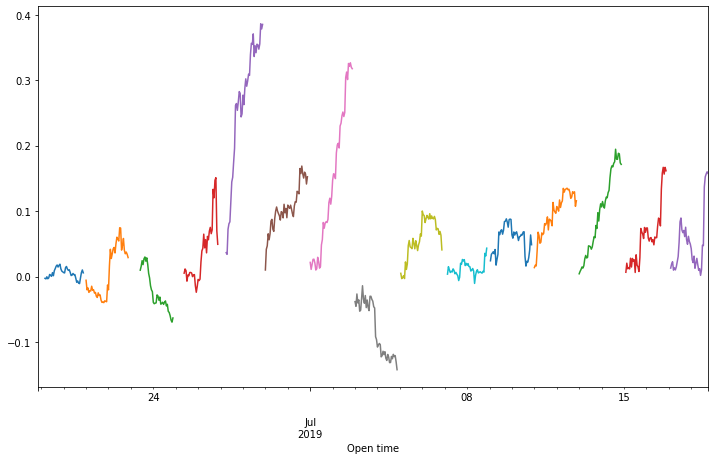

In [28]:
intv_dates = data.index[::48].to_list()
all_sigs = pd.DataFrame()
all_prices = pd.DataFrame()
last_id = len(intv_dates)-1
for c,i in enumerate(intv_dates):

    st = i 
    try:
        end = intv_dates[c+1]
    except:
        end = portmaker.to_dt(int(portmaker.current_milli_time()))
    print(st,end)
    intv_data =data[st:end]
    high = intv_data.High
    prices = intv_data #[:intv].High

    prices = make_bands(prices)
    signal = make_signal(prices,"BTCUSDT")
    all_sigs = pd.concat([all_sigs,signal])
    all_prices = pd.concat([all_prices,prices])
    #plot_signal(prices,signal)
    

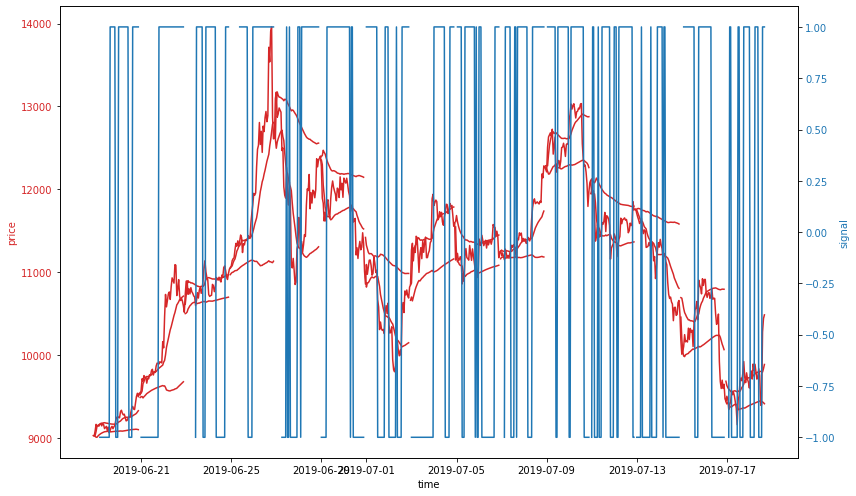

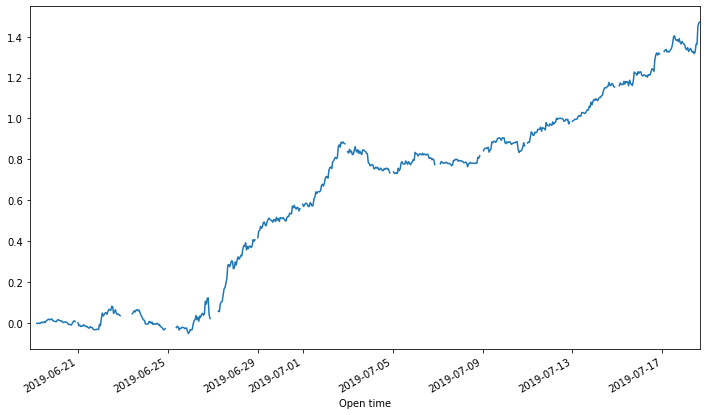

In [25]:
plot_signal(all_prices,all_sigs)
all_sigs['Market Return'] = np.log(all_sigs["Close"] / all_sigs["Close"].shift(1))
all_sigs['Strategy Return'] = all_sigs['Market Return'] * all_sigs['Position']

all_sigs['Strategy Return'].cumsum().plot(figsize=(12,7))

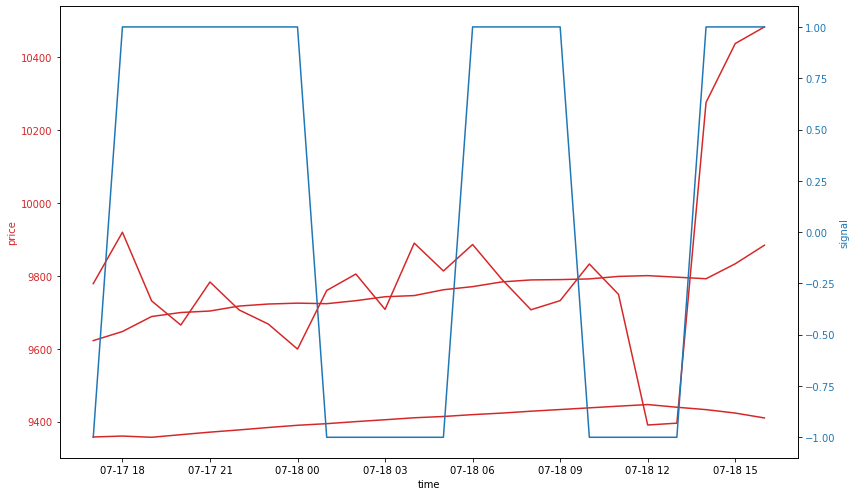

In [27]:
plot_signal(all_prices[-24:],all_sigs[-24:])